In [ ]:
!gmx --version

In [ ]:
!mkdir sim
%cd sim

In [ ]:
%%bash

git clone https://github.com/m3g/packmol.git
cd packmol
git checkout v20.3.5
./configure
make

In [ ]:
!git clone https://github.com/zhmurov/trappeua
!mv trappeua/trappeua.ff .
!rm -rf trappeua

In [ ]:
!packmol/packmol < input/packmol.inp

In [ ]:
!cp input/topol.top .

In [ ]:
!gmx editconf -f conf.pdb -o conf.gro -box 4 4 4
!gmx grompp -f input/em.mdp -c conf.gro -o em.tpr
!gmx mdrun -deffnm em -nt 4

In [ ]:
!gmx grompp -f input/nvt.mdp -c em.gro -o nvt.tpr
!gmx mdrun -deffnm nvt -nt 4

In [ ]:
!gmx grompp -f input/npt.mdp -c nvt.gro -o npt.tpr
!gmx mdrun -deffnm npt -nt 4

In [ ]:
%%bash

ELECTRIC_FIELD=1.0
cp input/md_iso_E.mdp md_iso_${ELECTRIC_FIELD}.mdp
sed -i "s/ELECTRIC_FIELD/${ELECTRIC_FIELD}/g" md_iso_${ELECTRIC_FIELD}.mdp

In [ ]:
!gmx grompp -f md_iso_${ELECTRIC_FIELD}.mdp -c npt.gro -o md_iso_${ELECTRIC_FIELD}.tpr
!gmx mdrun -deffnm md_iso_${ELECTRIC_FIELD} -nt 4

/home/zhmurov/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


1 0.019472180513961046
2 0.02151580075602111
3 0.013106596486067157
4 0.017200491075241908
5 0.023803090387302772
6 0.010123922657946816
7 0.027532342249895203
8 0.02013023389520574
9 0.012808972549698705
10 0.013557737709451345
11 0.012915863060240507
12 0.02092574364208244
13 0.012420389644851482
14 0.02081674351631213
15 0.008846424984698231
16 0.016326629863304798
17 0.018252025963535368
18 0.02831572673413163
19 0.02437417365977157
20 0.03266376518721137
21 0.03586427343209175
22 0.03374436625184707
23 0.027315279228911526
24 0.03439720763924159
25 0.032288429705509825
26 0.04255467851013406
27 0.03805081983304581
28 0.03505534243703701
29 0.04461466856644691
30 0.03300467031553855
31 0.03756150816643744
32 0.0521938315912579
33 0.049936017526351906
34 0.03506349843982337
35 0.03231776444003076
36 0.0585842926196517
37 0.04122151530652507
38 0.04139746642172737
39 0.028916716791239527
40 0.031541027939948174
41 0.0384279197066304
42 0.02934053123806324
43 0.02730034017220495
44 0.

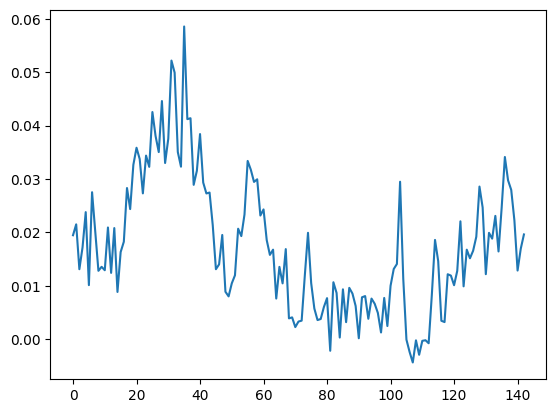

In [4]:
import MDAnalysis as mda

electric_field = "0.1"

u = mda.Universe("data/short/conf.pdb", "data/short/md_iso_" + electric_field + ".xtc")
step = 0
order_params = []
times  = []
for ts in u.trajectory:
    box = ts.dimensions
    cosxi2 = 0.0
    ncosxi2 = 0
    ends1 = u.select_atoms("name N1")
    ends2 = u.select_atoms("name C19")
    for i in range(0, len(ends1) - 1):
        endi1 = ends1[i].position
        endi2 = ends2[i].position
        ri = endi2 - endi1
        ri[0] = ri[0] - round(ri[0] / box[0]) * box[0]
        ri[1] = ri[1] - round(ri[1] / box[1]) * box[1]
        ri[2] = ri[2] - round(ri[2] / box[2]) * box[2]
        ri_len = (ri[0]*ri[0] + ri[1]*ri[1] + ri[2]*ri[2]) ** 0.5
        for j in range(i + 1, len(ends1)):
            endj1 = ends1[j].position
            endj2 = ends2[j].position
            rj = endj2 - endj1
            rj[0] = rj[0] - round(rj[0] / box[0]) * box[0]
            rj[1] = rj[1] - round(rj[1] / box[1]) * box[1]
            rj[2] = rj[2] - round(rj[2] / box[2]) * box[2]
            rj_len = (rj[0]*rj[0] + rj[1]*rj[1] + rj[2]*rj[2]) ** 0.5
            cosxi = (ri[0]*rj[0] + ri[1]*rj[1] + ri[2]*rj[2]) / (ri_len * rj_len)
            cosxi2 += cosxi*cosxi
            ncosxi2 += 1
    cosxi2 /= ncosxi2
    order_param = (3.0*cosxi2 - 1.0)/2.0
    order_params.append(order_param)
    times.append(step)
    step += 1
    print(step, order_param)

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(times, order_params)
plt.show()
#fig.savefig("order_parameter_" + electric_field + ".png")